Train size before SMOTE: 63270
Train size after  SMOTE: 109586
Validation set size:     7404

=== Internal Validation Set ===
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      6393
           1       0.41      0.44      0.42      1011

    accuracy                           0.84      7404
   macro avg       0.66      0.67      0.66      7404
weighted avg       0.84      0.84      0.84      7404



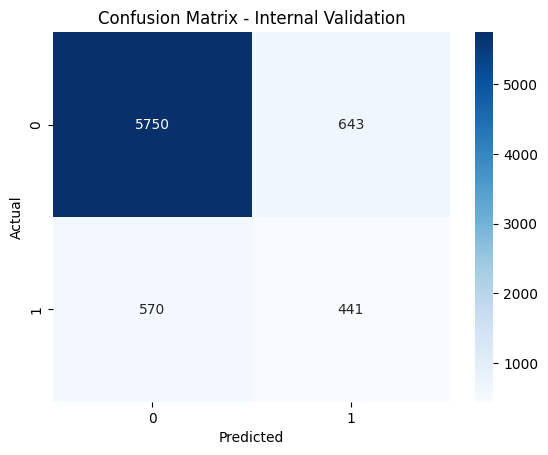


=== External Test Set ===
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      2636
           1       0.09      0.23      0.12       107

    accuracy                           0.87      2743
   macro avg       0.53      0.57      0.53      2743
weighted avg       0.93      0.87      0.90      2743



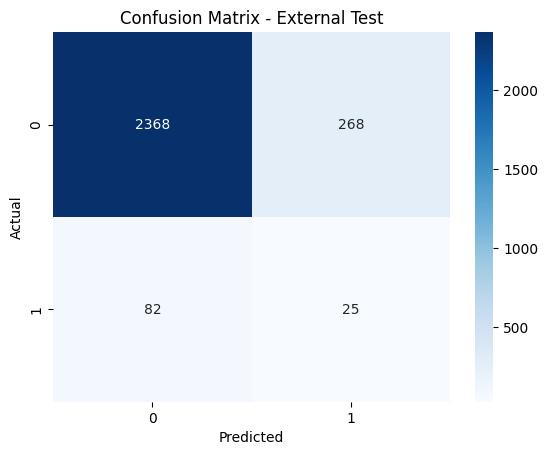

In [ ]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load main corpus (tokenized) and external test corpus
with open('/content/parole.pkl', 'rb') as f:
    df_caricato = pickle.load(f)

with open('/content/anfass_tagliato.pkl', 'rb') as f2:
  df_caricato2 = pickle.load(f2)

#Shuffle the full DataFrame to remove any ordering bias
df_caricato = shuffle(df_caricato, random_state=42)

#Get unique sentence indices and shuffle them
frasi_idx = df_caricato['frase_idx'].unique()
frasi_idx = shuffle(frasi_idx, random_state=42)

#Split sentence indices: 90% for train+val, 10% for internal test (not used here)
frasi_trainval, _ = train_test_split(frasi_idx, test_size=0.1, random_state=42)

#From train+val, split 10% for validation (i.e. 9% of total)
frasi_train, frasi_val = train_test_split(frasi_trainval, test_size=0.1, random_state=42)

#Filter DataFrames by sentence indices (internal train/val)
df_train = df_caricato[df_caricato['frase_idx'].isin(frasi_train)]
df_val   = df_caricato[df_caricato['frase_idx'].isin(frasi_val)]

#Separate features (X) and labels (y) for internal train/val
X_train = df_train.drop(columns=['segmenta', 'frase_idx', 'token'])
y_train = df_train['segmenta']
X_val   = df_val.drop(columns=['segmenta', 'frase_idx', 'token'])
y_val   = df_val['segmenta']

# Preprocessing: scale numeric, leave binary POS as it is
numerical_cols = ['frase_len_token', 'frase_len_char', 'token_len_char', 'distanza_da_prima_parola']
binary_cols    = ['NOUN','VERB','ADJ','DET','ADP','PRON','PUNCT','ADV','NUM','CCONJ']

preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), numerical_cols)
], remainder='passthrough')

# Fit scaler on training, transform train+val
X_train_scaled = preprocessor.fit_transform(X_train)
X_val_scaled   = preprocessor.transform(X_val)

# Re-wrap as DataFrame if desired
X_train_scaled = pd.DataFrame(X_train_scaled,
                              columns=numerical_cols + binary_cols,
                              index=X_train.index)
X_val_scaled   = pd.DataFrame(X_val_scaled,
                              columns=numerical_cols + binary_cols,
                              index=X_val.index)

#Balance training set with SMOTE only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print(f"Train size before SMOTE: {len(X_train)}")
print(f"Train size after  SMOTE: {len(X_train_res)}")
print(f"Validation set size:     {len(X_val)}")

#Train the Decision Tree on the resampled training set
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_res, y_train_res)

#Evaluate on internal validation set
y_pred_val = clf.predict(X_val_scaled)
print("\n=== Internal Validation Set ===")
print(classification_report(y_val, y_pred_val))

cm_val = confusion_matrix(y_val, y_pred_val)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Internal Validation')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Prepare the external test set in the same way
df_caricato2 = shuffle(df_caricato2, random_state=42)

X_test_ext = df_caricato2.drop(columns=['segmenta', 'frase_idx', 'token'])
y_test_ext = df_caricato2['segmenta']

# Apply the same scaler (do NOT refit)
X_test_ext_scaled = preprocessor.transform(X_test_ext)
X_test_ext_scaled = pd.DataFrame(X_test_ext_scaled,
                                 columns=numerical_cols + binary_cols,
                                 index=X_test_ext.index)

#Evaluate on external test set
y_pred_ext = clf.predict(X_test_ext_scaled)
print("\n=== External Test Set ===")
print(classification_report(y_test_ext, y_pred_ext))

cm_ext = confusion_matrix(y_test_ext, y_pred_ext)
sns.heatmap(cm_ext, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - External Test')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
